# Picnic Hackathon 🥇✅💯
 **When great customer support meets data**


## Why the challenge?
One of our core beliefs is to offer our customers the best support possible, by allowing them, for example, to send in pictures of defect products they wish to be reimbursed for. But processing these pictures is very time-consuming as it is all done manually.

## What is the challenge?
The challenge we propose is the following: As a first step in helping customer support, come up with a way of labeling every picture that comes in according to the product that is in the picture. To keep with the Picnic spirit, we encourage to be as innovative and creative with your solutions as possible.

## Dataset
To that end, we offer the following [dataset](https://github.com/Younes-Charfaoui/Picnic-Hackathon/blob/master/images/picnic_logo.png) of pictures of defect items.

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from keras_preprocessing.image import ImageDataGenerator

path_to_folder = 'gdrive/My Drive/Dataset/The Picnic Hackathon 2019/'

In [0]:
df = pd.read_csv(path_to_folder + "train.tsv",  sep='\t')

In [0]:
datagen = ImageDataGenerator(rescale=1./255, validation_split = 0.3)

In [38]:
train_generator = datagen.flow_from_dataframe(dataframe=df, directory=path_to_folder + "train/", 
                                              x_col="file", y_col="label", 
                                              class_mode="categorical", 
                                              target_size=(32,32), 
                                              batch_size=32,
                                              subset = "training")

valid_generator = datagen.flow_from_dataframe(dataframe=df, directory=path_to_folder + "train/", 
                                              x_col="file", y_col="label", 
                                              class_mode="categorical", 
                                              target_size=(32,32), 
                                              batch_size=32,
                                              subset = "validation")

Found 5081 images belonging to 25 classes.
Found 2177 images belonging to 25 classes.


In [0]:
labels = train_generator.class_indices
labels = {v: k for k, v in labels.items()}

In [40]:
print(labels)

{0: 'Asparagus, string beans & brussels sprouts', 1: 'Bananas, apples & pears', 2: 'Bell peppers, zucchinis & eggplants', 3: 'Berries & cherries', 4: 'Broccoli, cauliflowers, carrots & radish', 5: 'Cheese', 6: 'Citrus fruits', 7: 'Cucumber, tomatoes & avocados', 8: 'Eggs', 9: 'Fish', 10: 'Fresh bread', 11: 'Fresh herbs', 12: 'Kiwis, grapes & mango', 13: 'Lunch & Deli Meats', 14: 'Milk', 15: 'Minced meat & meatballs', 16: 'Nectarines, peaches & apricots', 17: 'Onions, leek, garlic & beets', 18: 'Pineapples, melons & passion fruit', 19: 'Pork, beef & lamb', 20: 'Potatoes', 21: 'Poultry', 22: 'Pre-baked breads', 23: 'Pudding, yogurt & quark', 24: 'Salad & cress'}


In [41]:
X, y = train_generator.next()

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:885: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


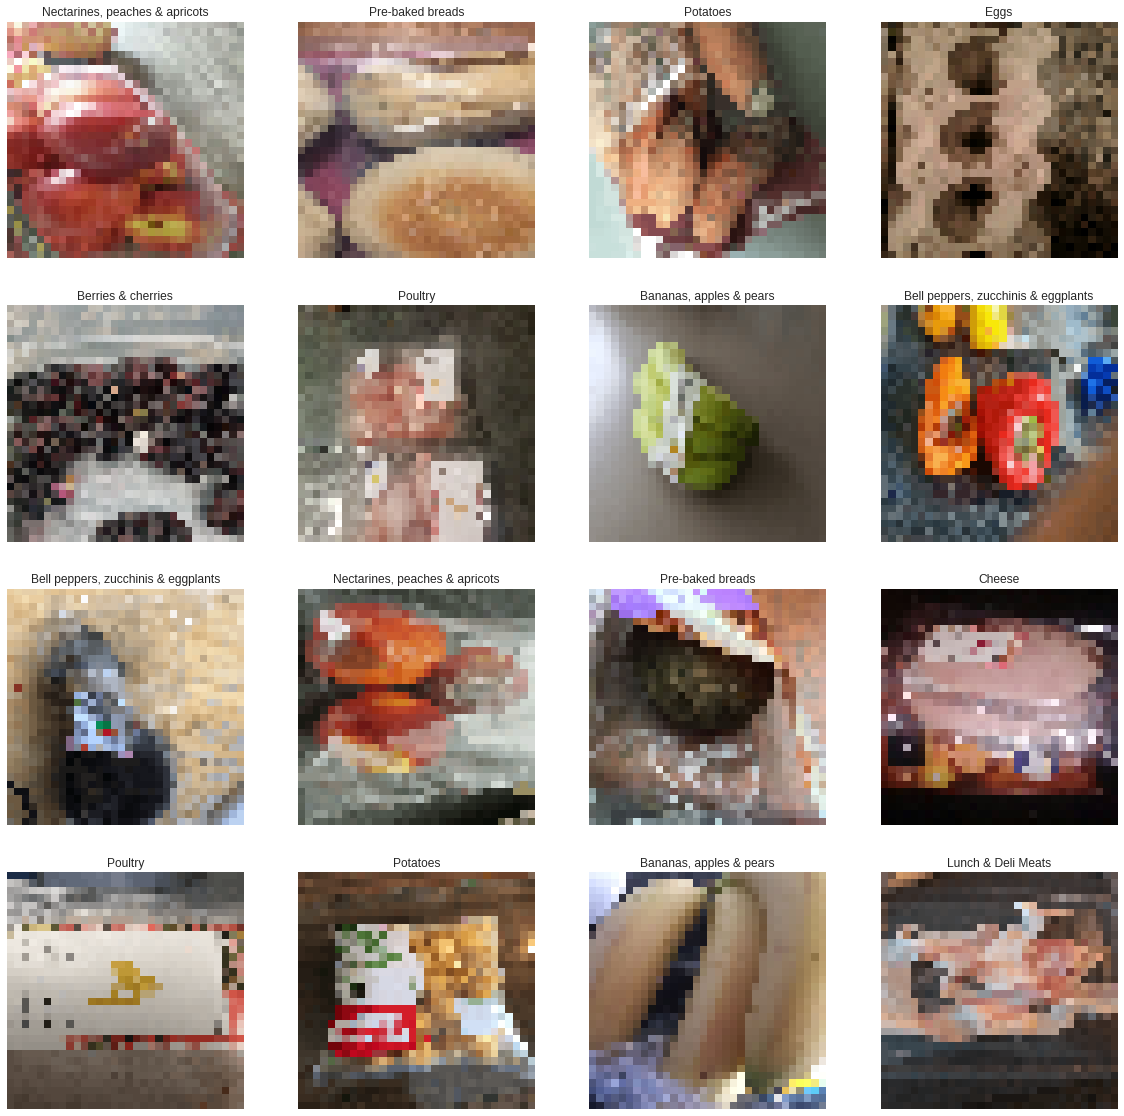

In [42]:
fig = plt.figure(figsize = (20,20))
for i in range(16):
  ax = fig.add_subplot(4,4, i+1, xticks = [], yticks = [])
  ax.imshow(X[i])
  ax.set_title(labels[np.argmax(y[i])])

In [0]:
from keras.models import Sequential
from keras.layers import Dropout, Conv2D, MaxPooling2D, Activation, Dense, Flatten

In [43]:
# Building simple model
model = Sequential()
model.add(Conv2D(16, (3, 3), padding='same',
                 input_shape=(32,32,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(25, activation='softmax'))
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 32, 32, 16)        448       
_________________________________________________________________
activation_20 (Activation)   (None, 32, 32, 16)        0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 16, 16, 16)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               2097664   
_________________________________________________________________
activation_21 (Activation)   (None, 512)               0         
__________

In [0]:
model.compile(optimizer = 'rmsprop', loss="categorical_crossentropy", metrics=["accuracy"])

In [0]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size

In [0]:
model.fit_generator(generator=train_generator, epochs=10, steps_per_epoch=STEP_SIZE_TRAIN)

Epoch 1/10


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:885: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


 14/226 [>.............................] - ETA: 59:52 - loss: 3.5730 - acc: 0.0759